<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Problem </h1>

<h2> 2.1 Data </h2>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1>3. Exploratory Data Analysis </h1>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<h2> 3.1 Reading data and basic stats </h2>

In [2]:
df = pd.read_csv("/Users/anand/Documents/Datasets/Quora Question Pair Similarity Problem/train.csv")

In [3]:
df.shape

(404290, 6)

In [4]:
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


**Observation**
- id: Looks like a rowId
- qid1/qid2: uniqueId for question 1 & 2 respectively
- question1/2: Questions in text format
- is_duplicate: wheather the tow questions are duplicates of each other 

<h3> 3.2.1 Distribution of data points among output classes </h3>
- Number of duplicate(similar) and non-duplicate(non-similar) questions

In [6]:
df.groupby('is_duplicate')['id'].count()

is_duplicate
0    255027
1    149263
Name: id, dtype: int64

In [7]:
print(type(df.groupby('is_duplicate')['id'].count()))

<class 'pandas.core.series.Series'>


<Axes: xlabel='is_duplicate'>

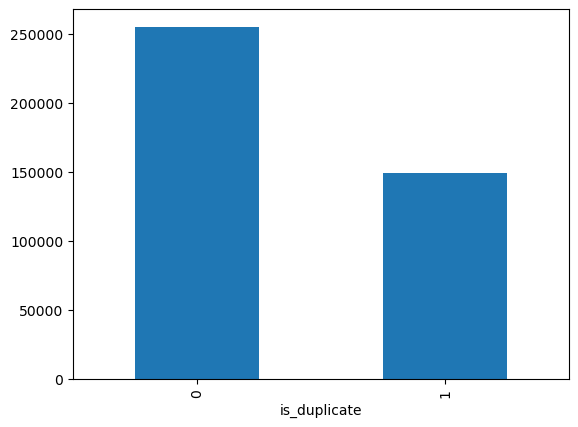

In [8]:
df.groupby('is_duplicate')['id'].count().plot.bar()

In [9]:
pd.DataFrame(df.groupby('is_duplicate')['id'].count())

id
is_duplicate        
0             255027
1             149263

In [10]:
# Number of unique questions
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
unique_qs

537933

In [11]:
np.sum(qids.value_counts()>1)

111780

In [12]:
qs_morethan_onetime = np.sum(qids.value_counts()>1)

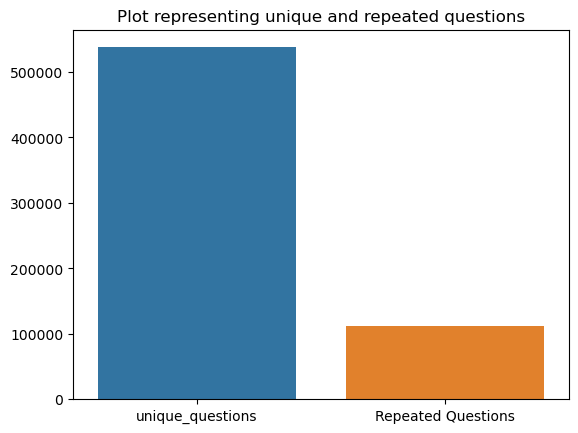

In [13]:
x = ['unique_questions', 'Repeated Questions']
y = [unique_qs, qs_morethan_onetime]

plt.figure()
plt.title('Plot representing unique and repeated questions')
sns.barplot(x=x,y=y)
plt.show()

In [14]:
# Checking for duplicates 
pair_duplicates = df[['qid1', 'qid2', 'is_duplicate']].groupby(['qid1', 'qid2']).count().reset_index()
pair_duplicates

qid1    qid2  is_duplicate
0            1       2             1
1            3       4             1
2            3  282170             1
3            3  380197             1
4            3  488853             1
...        ...     ...           ...
404285  537924  537925             1
404286  537926  537927             1
404287  537928  537929             1
404288  537930  537931             1
404289  537932  537933             1

[404290 rows x 3 columns]

In [15]:
pair_duplicates.shape

(404290, 3)

Text(0, 0.5, 'Number of question')

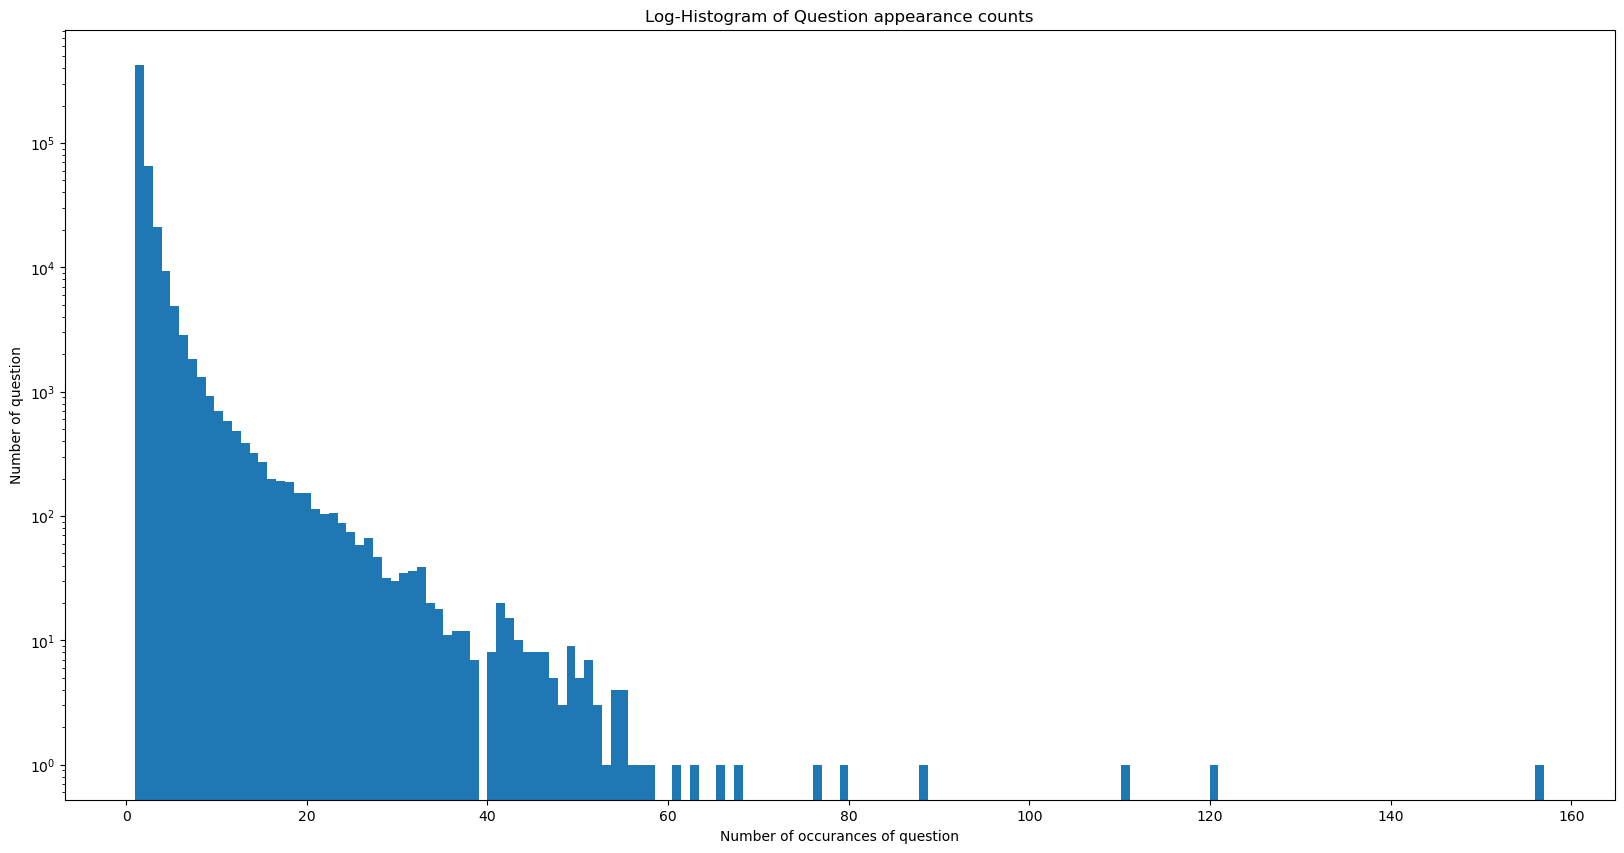

In [16]:
# How many questions occur how many times
plt.figure(figsize=(20,10))
plt.hist(qids.value_counts(), bins=160)
plt.yscale('log')
plt.title('Log-Histogram of Question appearance counts')
plt.xlabel('Number of occurances of question')
plt.ylabel('Number of question')

In [17]:
qids.value_counts().max()

157

In [18]:
# Checking the rows with any null values in any column
df[df.isnull().any(1)]

id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0

In [19]:
# Filling the null values with ' '
df = df.fillna('')

In [20]:
df[df.isnull().any(1)]

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []

## Basic Feature Extraction

- freq_qid1: Frequency of qid1's
- freq_qid2: Frequency of qid2's
- q1len: Length of q1
- q2len: Length of q2
- q1_n_words: Number of words in Question 1
- q2_n_words: Number of words in Question 2
- word_common: number of common unique words in que1 and que2
- word_total: #words in q1 + #words in q2
- word_share = word_common/word_total
- freq_q1+freq_q2: sum total of freq of qid1 and qid2
- freq_q1-freq_q2: absolute difference of frequency of qid1 and qid2

In [21]:
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [22]:
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
df['q1len'] = df['question1'].str.len()
df['q2len'] = df['question2'].str.len()
df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the step by step guide to invest in sh...             0          1   
1  What would happen if the Indian government sto...             0          4   
2  How can Internet speed be increased by hacking...             0          1   
3  Find the remainder when [math]23^{24}[/math] i...             0          1   
4            Which fish would survive in salt water?             0          3   

   freq_qid2  q1len  q2len  q1_n_words  q2_n_words  
0          1     66     57          14          12  
1          1     51     88           8          13  
2          1     73     59          14          10  
3          1     50     65          11           9  
4          1     76     39          13           7

In [23]:
def normalized_word_common(row):
    w1 = set(map(lambda word: word.lower().strip() ,row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip() ,row['question2'].split(" ")))
    return 1.0*len(w1 & w2)
df['word_common'] = df.apply(normalized_word_common, axis=1)

In [24]:
def normalized_word_total(row):
    w1 = set(map(lambda word: word.lower().strip() ,row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip() ,row['question2'].split(" ")))
    return 1.0*(len(w1) + len(w2))
df['word_total'] = df.apply(normalized_word_total, axis=1)

In [25]:
def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip() ,row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip() ,row['question2'].split(" ")))
    return 1.0*len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

In [26]:
df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

In [27]:
print("Minimum length of the questions in question1: ", min(df['q1_n_words']))
print("Minimum length of the questions in question2: ", min(df['q2_n_words']))

print("Number of questions with minimum length in question1: ", df[df['q1_n_words']==min(df['q1_n_words'])].shape[0])
print("Number of questions with minimum length in question2: ", df[df['q1_n_words']==min(df['q1_n_words'])].shape[0])

Minimum length of the questions in question1:  1
Minimum length of the questions in question2:  1
Number of questions with minimum length in question1:  67
Number of questions with minimum length in question2:  67


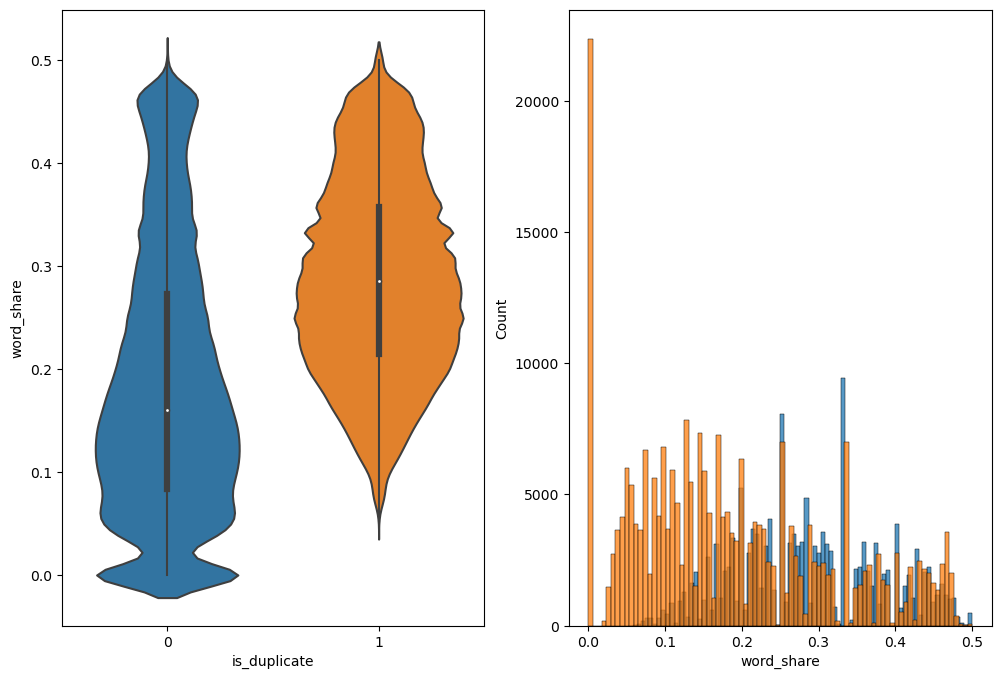

In [28]:
# Feature : Word Share
plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.histplot(df[df['is_duplicate']==1.0]['word_share'][0:], label = "1")
sns.histplot(df[df['is_duplicate']==0.0]['word_share'][0:], label = "0")
plt.show()

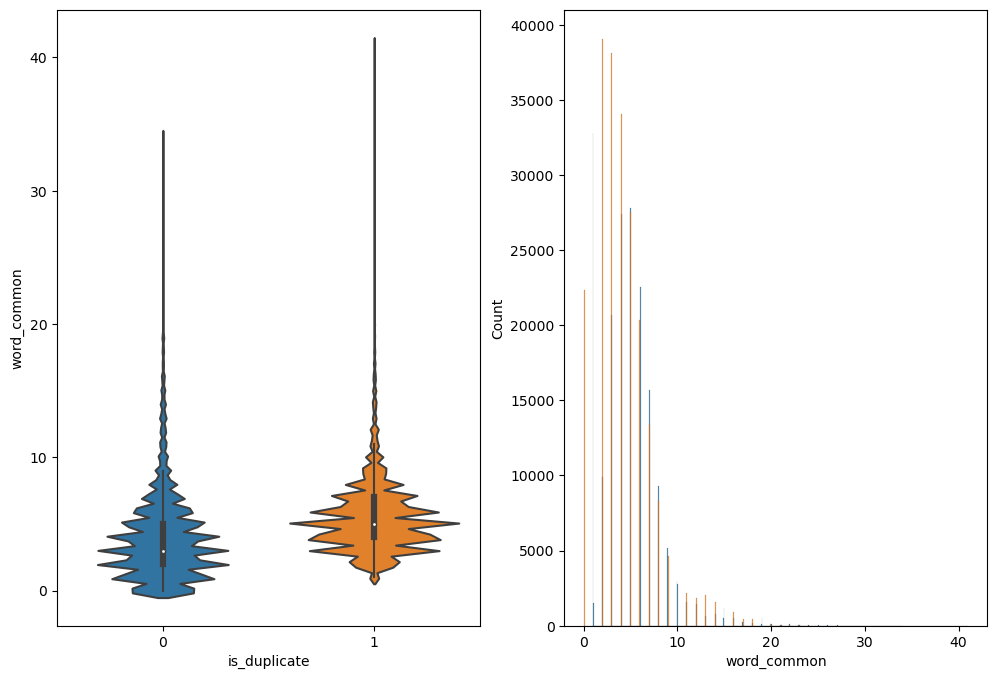

In [29]:
# Feature : Word Common
plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y = 'word_common', data = df[0:])

plt.subplot(1,2,2)
sns.histplot(df[df['is_duplicate']==1.0]['word_common'][0:], label = "1")
sns.histplot(df[df['is_duplicate']==0.0]['word_common'][0:], label = "0")
plt.show()

## Advanced Feature Extraction

#### Preprocessing of Text
- Removing html tags
- Removing Puntuations
- Performing stemming
- Removing Stopwords
- Expanding contractions etc.

In [3]:
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [31]:
type('')

str

In [32]:
SAFE_DIV = 0.0001

STOP_WORDS = stopwords.words("english")

def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

### NLP and Fuzzy Features

**Definition:**
- Token: Get a token by splitting sentence at spaces
- Stop Word: Stop words as per NLTK
- Word: A token that is not a stop word

**Features:**
- cwc_min: Ratio of common word count to min length of word count of Q1 and Q2.<br>
    i.e cwc_min = common_word_count/(min(len(q1_words),len(q2_words))
- cwc_max: Ratio of common word count to max length of word count of Q1 and Q2.<br>
    i.e cwc_max = common_word_count/(max(len(q1_words),len(q2_words))
- csc_min: Ratio of common stop count to min length of stop count of Q1 and Q2.<br>
    i.e csc_min = common_stop_count/(min(len(q1_stops),len(q2_stops))
- csc_max: Ratio of common stop count to max length of stop count of Q1 and Q2.<br>
    i.e csc_min = common_stop_count/(max(len(q1_stops),len(q2_stops))
- ctc_min: Ratio of common token count to min length of token count of Q1 and Q2.<br>
    i.e ctc_min = common_token_count/(min(len(q1_tokens),len(q2_tokens))
- ctc_max: Ratio of common token count to max length of token count of Q1 and Q2.<br>
    i.e ctc_max = common_token_count/(max(len(q1_tokens),len(q2_tokens))
- last_word_eq: Check if the last word of both questions is equal or not <br>
    last_word_eq = int(q1_tokens[-1]==q2_tokens[-1])
- first_word_eq: Check if the first word of both questions is equal or not <br>
    first_word_eq = int(q1_tokens[0]==q2_tokens[0]) 
- abs_len_diff: Abs. length difference <br>
    abs_len_diff = abs(len(q1_tokens)-len(q2_tokens))
- mean_len: Average Token length of both questions <br>
    mean_len = (len(q1_tokens)-len(q2_tokens))/2
- fuzz_ratio
- fuzz_partial_ratio
- token_sort_ratio
- token_set_ratio
- longest_substr_ratio: Ratio of length longest common substring to min length of token count of Q1 and Q2 <br>
    longest_substr_ratio = len(longest common substring)/min(len(q1_tokens),len(q2_tokens))

In [33]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the sentence into tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    # Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    token_features[0] = common_word_count / min(len(q1_words)+ SAFE_DIV, len(q2_words)+SAFE_DIV)
    token_features[1] = common_word_count / max(len(q1_words)+ SAFE_DIV, len(q2_words)+SAFE_DIV)
    token_features[2] = common_stop_count / min(len(q1_stops)+ SAFE_DIV, len(q2_stops)+SAFE_DIV)
    token_features[3] = common_stop_count / max(len(q1_stops)+ SAFE_DIV, len(q2_stops)+SAFE_DIV)
    token_features[4] = common_token_count / min(len(q1_tokens)+ SAFE_DIV, len(q2_tokens)+SAFE_DIV)
    token_features[5] = common_token_count / max(len(q1_tokens)+ SAFE_DIV, len(q2_tokens)+SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1]==q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0]==q2_tokens[0])
    
    # Absolute length difference
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    # Average token length of both Questions
    token_features[9] = (len(q1_tokens)+len(q2_tokens))/2
    
    return token_features

In [34]:
def get_longest_substr_ratio(a,b):
    strs = list(distance.lcsubstrings(a,b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0])/(min(len(a), len(b)) + 1)

In [35]:
def extract_features(df):
    # preprocessing each question
    df['question1'] = df["question1"].fillna("").apply(preprocess)
    df['question2'] = df["question2"].fillna("").apply(preprocess)
    
    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"] = list(map(lambda x: x[0], token_features))
    df["cwc_max"] = list(map(lambda x: x[1], token_features))
    df["csc_min"] = list(map(lambda x: x[2], token_features))
    df["csc_max"] = list(map(lambda x: x[3], token_features))
    df["ctc_min"] = list(map(lambda x: x[4], token_features))
    df["ctc_max"] = list(map(lambda x: x[5], token_features))
    df["last_word_eq"] = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"] = list(map(lambda x: x[8], token_features))
    df["mean_len"] = list(map(lambda x: x[9], token_features))
    
    # Computing Fuzzy Features and Merging with Dataset
    
    print('fuzzy features...')
    
    df["token_set_ratio"] = df.apply(lambda x: fuzz.token_set_ratio(x['question1'],x['question2']), axis=1)
    df['token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(x['question1'],x['question2']), axis=1)
    df['fuzz_ratio'] = df.apply(lambda x: fuzz.QRatio(x['question1'],x['question2']), axis=1)
    df['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(x['question1'],x['question2']), axis=1)
    df['longest_substr_ratio'] = df.apply(lambda x: get_longest_substr_ratio(x['question1'],x['question2']), axis=1)

In [36]:
extract_features(df)

token features...
fuzzy features...


In [37]:
df.head(2)

id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   

                                           question2  is_duplicate  freq_qid1  \
0  what is the step by step guide to invest in sh...             0          1   
1  what would happen if the indian government sto...             0          4   

   freq_qid2  q1len  q2len  ...   ctc_max  last_word_eq  first_word_eq  \
0          1     66     57  ...  0.785709           0.0            1.0   
1          1     51     88  ...  0.466664           0.0            1.0   

   abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  fuzz_ratio  \
0           2.0      13.0              100                93          93   
1           5.0      12.5               86                63          66   

   fuzz_partial_ratio  longest_substr_ratio  
0                 100              0.982759  
1                  75              0.596154  

[2 rows x 32 columns]

In [38]:
df.to_csv("nlp_features_train.csv", index=False)

In [4]:
df = pd.read_csv("nlp_features_train.csv")
df.head(2)

id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   

                                           question2  is_duplicate  freq_qid1  \
0  what is the step by step guide to invest in sh...             0          1   
1  what would happen if the indian government sto...             0          4   

   freq_qid2  q1len  q2len  ...   ctc_max  last_word_eq  first_word_eq  \
0          1     66     57  ...  0.785709           0.0            1.0   
1          1     51     88  ...  0.466664           0.0            1.0   

   abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  fuzz_ratio  \
0           2.0      13.0              100                93          93   
1           5.0      12.5               86                63          66   

   fuzz_partial_ratio  longest_substr_ratio  
0                 100              0.982759  
1                  75              0.596154  

[2 rows x 32 columns]

<h3>3.5.1 Analysis of extracted features </h3>

<h4> 3.5.1.1 Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [5]:
df_duplicate = df[df['is_duplicate']==1]
df_nonduplicate = df[df['is_duplicate']==0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate['question1'], df_duplicate['question2']]).flatten()
n = np.dstack([df_nonduplicate['question1'], df_nonduplicate['question2']]).flatten()

print("Number of data points in class 1:", len(p))
print("Number of data points in class 0:", len(n))
np.savetxt('train_p.txt', p, delimiter = ' ', fmt='%s')
np.savetxt('train_n.txt', p, delimiter = ' ', fmt='%s')

Number of data points in class 1: 298526
Number of data points in class 0: 510054


In [6]:
# Reading the text files and removing the stop words
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add('said')
stopwords.add('br')
stopwords.add(' ')
stopwords.remove('not')

stopwords.remove('no')
#stopwords.remove('good')
#stopwords.remove('love')
stopwords.remove('like')
#stopwords.remove('best')
#stopwords.remove('!')
print('Total number of words in duplicate pair questions: ', len(textp_w))
print('Total number of words in non duplicate pair questions: ', len(textn_w))

Total number of words in duplicate pair questions:  16110077
Total number of words in non duplicate pair questions:  16110077


__ Word Clouds generated from  duplicate pair question's text __

Word cloud for duplicate Question pairs


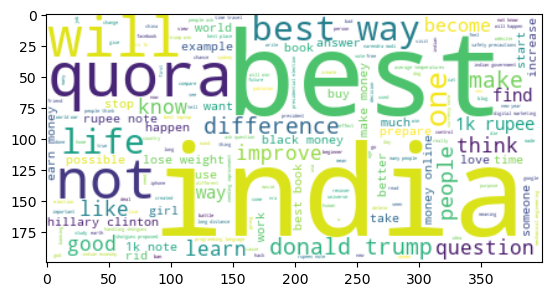

In [7]:
wc = WordCloud(background_color='white', max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print('Word cloud for duplicate Question pairs')
plt.imshow(wc, interpolation='bilinear')
##plt.axis('off')
plt.show()

Word Cloud for non-Duplicate Question pairs:


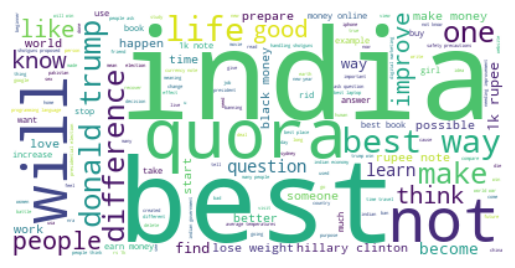

In [8]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h4> 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

/Users/anand/opt/anaconda3/envs/analytics/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/anand/opt/anaconda3/envs/analytics/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/anand/opt/anaconda3/envs/analytics/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/anand/opt/anaconda3/envs/analytics/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



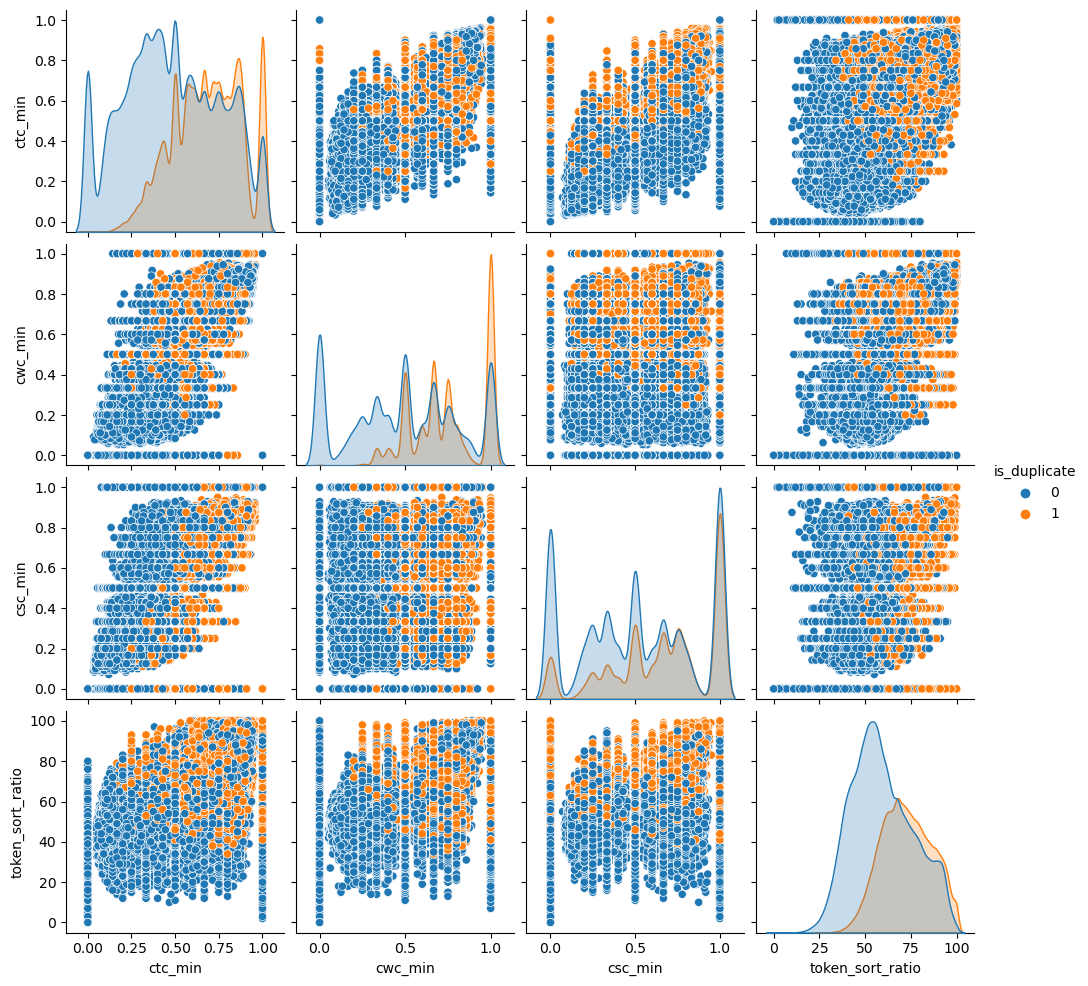

In [9]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

/Users/anand/opt/anaconda3/envs/analytics/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/anand/opt/anaconda3/envs/analytics/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



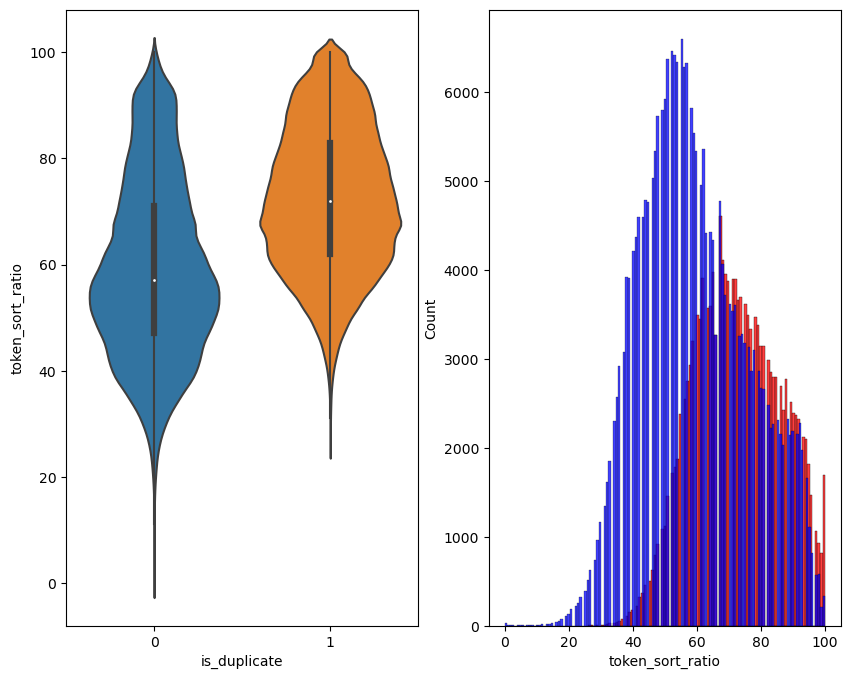

In [10]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y='token_sort_ratio', data=df[0:])

plt.subplot(1,2,2)
sns.histplot(df[df['is_duplicate']==1]['token_sort_ratio'][0:], label='1', color='red')
sns.histplot(df[df['is_duplicate']==0]['token_sort_ratio'][0:], label='0', color='blue')
plt.show()

/Users/anand/opt/anaconda3/envs/analytics/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/anand/opt/anaconda3/envs/analytics/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



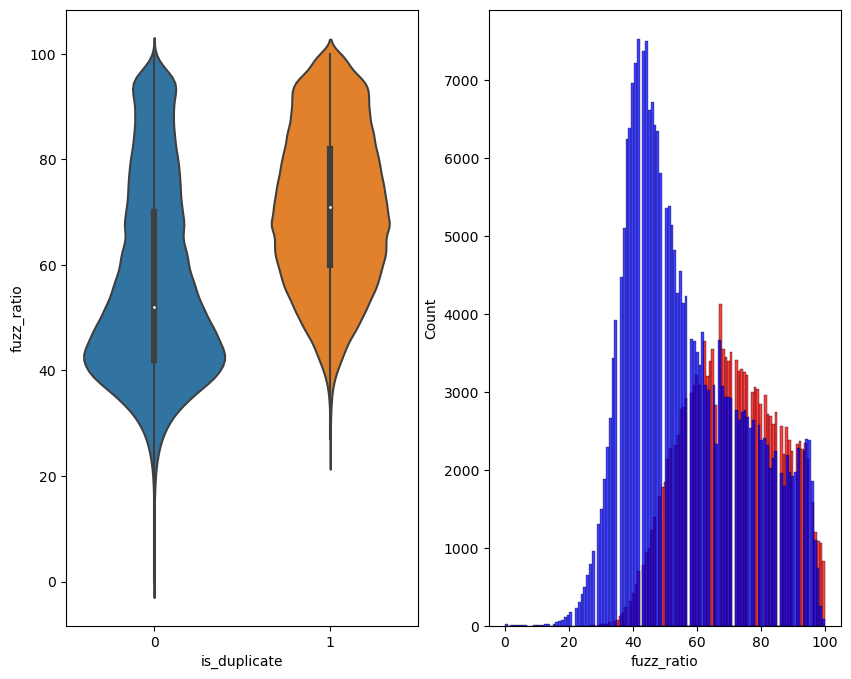

In [11]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y='fuzz_ratio', data=df[0:])

plt.subplot(1,2,2)
sns.histplot(df[df['is_duplicate']==1]['fuzz_ratio'][0:], label='1', color='red')
sns.histplot(df[df['is_duplicate']==0]['fuzz_ratio'][0:], label='0', color='blue')
plt.show()

<h3>3.5.2 Visualization </h3>

In [12]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

In [13]:
dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max','last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len','token_set_ratio', 'token_sort_ratio', 'fuzz_ratio','fuzz_partial_ratio', 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [14]:
tsne2d = TSNE(
    n_components=2,
    init='random', #pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
    ).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.014s...
[t-SNE] Computed neighbors for 5000 samples in 0.253s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.121373
[t-SNE] Computed conditional probabilities in 0.093s
[t-SNE] Iteration 50: error = 85.3473511, gradient norm = 0.0942231 (50 iterations in 0.949s)
[t-SNE] Iteration 100: error = 70.8446579, gradient norm = 0.0134120 (50 iterations in 0.690s)
[t-SNE] Iteration 150: error = 68.8838501, gradient norm = 0.0076383 (50 iterations in 0.480s)
[t-SNE] Iteration 200: error = 68.0032501, gradient norm = 0.0055328 (50 iterations in 0.499s)
[t-SNE] Iteration 250: error = 67.4815216, gradient norm = 0.0044031

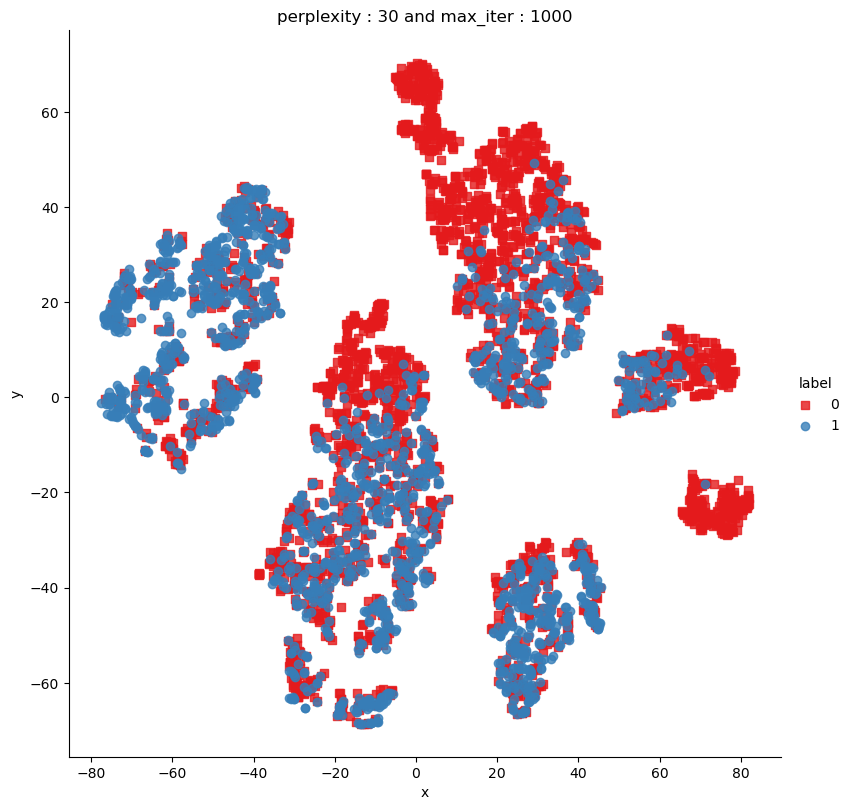

In [15]:
df_tsne = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df_tsne, x='x', y='y', hue='label',height=8, fit_reg=False,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

<h2> 3.6 Featurizing text data with tfidf weighted word-vectors </h2>

In [16]:
from tqdm import tqdm
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [17]:
df = pd.read_csv("/Users/anand/Documents/Datasets/Quora Question Pair Similarity Problem/train.csv")
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [22]:
questions = list(df['question1'])+list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False,)
tfidf.fit_transform(questions)

#dict key:word and value:tf
word2tfidf = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))

In [24]:
nlp = spacy.load('en_core_web_lg')

In [28]:
x = nlp('man')
len(x.vector)

300

In [32]:
vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progrss bar
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)


  1%|▏                                   | 2142/404290 [00:10<30:43, 218.18it/s]


  1%|▍                                   | 4491/404290 [00:20<29:51, 223.16it/s]


  2%|▌                                   | 6834/404290 [00:30<29:07, 227.38it/s]


  2%|▊                                   | 9150/404290 [00:40<27:58, 235.36it/s]


  3%|▉                                  | 11456/404290 [00:50<28:29, 229.82it/s]


  3%|█▏                                 | 13818/404290 [01:00<26:44, 243.32it/s]


  4%|█▍                                 | 16206/404290 [01:11<29:28, 219.41it/s]


  5%|█▌                                 | 18622/404290 [01:21<26:09, 245.78it/s]


  5%|█▊                                 | 21030/404290 [01:31<26:35, 240.23it/s]


  6%|██                                 | 23406/404290 [01:41<27:38, 229.66it/s]


  6%|██▏                                | 25761/404290 [01:51<26:21, 239.39it/s]


  7%|██▍                                | 28145/404290 [02:01<27:12, 230.47it/s]


  8%|██▋                                | 30548/404290 [02:11<25:39, 242.77it/s]


  8%|██▊                                | 32925/404290 [02:21<25:54, 238.93it/s]


  9%|███                                | 35302/404290 [02:32<26:00, 236.52it/s]


  9%|███▎                               | 37643/404290 [02:43<26:31, 230.41it/s]


 10%|███▍                               | 39998/404290 [02:53<26:22, 230.17it/s]


 10%|███▋                               | 42352/404290 [03:03<27:25, 219.90it/s]


 11%|███▊                               | 44741/404290 [03:13<26:06, 229.58it/s]


 12%|████                               | 47120/404290 [03:23<25:13, 235.98it/s]


 12%|████▎                              | 49496/404290 [03:33<25:34, 231.20it/s]


 13%|████▍                              | 51804/404290 [03:44<28:05, 209.17it/s]


 13%|████▋                              | 54151/404290 [03:54<25:25, 229.58it/s]


 14%|████▉                              | 56518/404290 [04:04<24:50, 233.26it/s]


 15%|█████                              | 58866/404290 [04:14<24:15, 237.34it/s]


 15%|█████▎                             | 61248/404290 [04:24<24:59, 228.71it/s]


 16%|█████▌                             | 63644/404290 [04:34<24:07, 235.33it/s]


 16%|█████▋                             | 65995/404290 [04:44<23:08, 243.57it/s]


 17%|█████▉                             | 68349/404290 [04:54<26:23, 212.18it/s]


 17%|██████                             | 70717/404290 [05:05<24:06, 230.61it/s]


 18%|██████▎                            | 73075/404290 [05:15<24:19, 226.90it/s]


 19%|██████▌                            | 75424/404290 [05:25<23:43, 231.02it/s]


 19%|██████▋                            | 77784/404290 [05:35<22:53, 237.80it/s]


 20%|██████▉                            | 80164/404290 [05:45<22:21, 241.58it/s]


 20%|███████▏                           | 82549/404290 [05:55<22:04, 242.88it/s]


 21%|███████▎                           | 84923/404290 [06:05<23:10, 229.64it/s]


 22%|███████▌                           | 87293/404290 [06:15<23:34, 224.03it/s]


 22%|███████▊                           | 89690/404290 [06:26<21:45, 240.99it/s]


 23%|███████▉                           | 92061/404290 [06:36<21:46, 238.90it/s]


 23%|████████▏                          | 94425/404290 [06:46<22:24, 230.46it/s]


 24%|████████▍                          | 96796/404290 [06:56<21:18, 240.60it/s]


 25%|████████▌                          | 99190/404290 [07:06<21:38, 234.92it/s]


 25%|████████▌                         | 101593/404290 [07:16<21:25, 235.48it/s]


 26%|████████▋                         | 103972/404290 [07:26<21:04, 237.59it/s]


 26%|████████▉                         | 106363/404290 [07:36<20:39, 240.40it/s]


 27%|█████████▏                        | 108746/404290 [07:46<20:55, 235.47it/s]


 27%|█████████▎                        | 111147/404290 [07:57<19:54, 245.37it/s]


 28%|█████████▌                        | 113534/404290 [08:07<21:44, 222.81it/s]


 29%|█████████▋                        | 115918/404290 [08:17<19:56, 240.97it/s]


 29%|█████████▉                        | 118303/404290 [08:27<19:55, 239.13it/s]


 30%|██████████▏                       | 120693/404290 [08:37<20:05, 235.24it/s]


 30%|██████████▎                       | 123045/404290 [08:47<20:18, 230.85it/s]


 31%|██████████▌                       | 125432/404290 [08:57<19:17, 240.88it/s]


 32%|██████████▊                       | 127827/404290 [09:07<19:16, 238.99it/s]


 32%|██████████▉                       | 130204/404290 [09:18<19:15, 237.12it/s]


 33%|███████████▏                      | 132568/404290 [09:28<19:44, 229.42it/s]


 33%|███████████▎                      | 134944/404290 [09:38<19:00, 236.14it/s]


 34%|███████████▌                      | 137313/404290 [09:48<19:15, 231.07it/s]


 35%|███████████▋                      | 139637/404290 [09:58<19:55, 221.35it/s]


 35%|███████████▉                      | 141991/404290 [10:08<18:26, 237.06it/s]


 36%|████████████▏                     | 144378/404290 [10:18<18:30, 234.07it/s]


 36%|████████████▎                     | 146744/404290 [10:28<19:02, 225.48it/s]


 37%|████████████▌                     | 149061/404290 [10:39<19:26, 218.80it/s]


 37%|████████████▋                     | 151385/404290 [10:49<18:11, 231.73it/s]


 38%|████████████▉                     | 153729/404290 [10:59<17:48, 234.45it/s]


 39%|█████████████▏                    | 156074/404290 [11:09<17:15, 239.79it/s]


 39%|█████████████▎                    | 158450/404290 [11:19<18:08, 225.82it/s]


 40%|█████████████▌                    | 160813/404290 [11:29<17:07, 236.98it/s]


 40%|█████████████▋                    | 163184/404290 [11:39<17:10, 234.00it/s]


 41%|█████████████▉                    | 165572/404290 [11:49<16:53, 235.44it/s]


 42%|██████████████                    | 167950/404290 [11:59<16:35, 237.44it/s]


 42%|██████████████▎                   | 170340/404290 [12:10<16:09, 241.25it/s]


 43%|██████████████▌                   | 172711/404290 [12:20<16:48, 229.60it/s]


 43%|██████████████▋                   | 175061/404290 [12:30<16:45, 228.05it/s]


 44%|██████████████▉                   | 177377/404290 [12:40<16:42, 226.39it/s]


 44%|███████████████                   | 179745/404290 [12:50<16:06, 232.26it/s]


 45%|███████████████▎                  | 182099/404290 [13:00<15:52, 233.26it/s]


 46%|███████████████▌                  | 184454/404290 [13:11<17:07, 213.93it/s]


 46%|███████████████▋                  | 186798/404290 [13:21<15:28, 234.23it/s]


 47%|███████████████▉                  | 189147/404290 [13:31<15:23, 233.03it/s]


 47%|████████████████                  | 191507/404290 [13:41<15:01, 235.93it/s]


 48%|████████████████▎                 | 193868/404290 [13:51<14:59, 233.97it/s]


 49%|████████████████▌                 | 196223/404290 [14:01<14:28, 239.52it/s]


 49%|████████████████▋                 | 198609/404290 [14:11<14:40, 233.60it/s]


 50%|████████████████▉                 | 200953/404290 [14:21<14:31, 233.45it/s]


 50%|█████████████████                 | 203312/404290 [14:31<14:20, 233.51it/s]


 51%|█████████████████▎                | 205679/404290 [14:41<13:42, 241.53it/s]


 51%|█████████████████▍                | 208047/404290 [14:52<14:04, 232.36it/s]


 52%|█████████████████▋                | 210409/404290 [15:02<13:51, 233.27it/s]


 53%|█████████████████▉                | 212770/404290 [15:12<13:16, 240.37it/s]


 53%|██████████████████                | 215121/404290 [15:22<14:02, 224.61it/s]


 54%|██████████████████▎               | 217460/404290 [15:32<13:28, 231.16it/s]


 54%|██████████████████▍               | 219801/404290 [15:42<13:07, 234.31it/s]


 55%|██████████████████▋               | 222137/404290 [15:52<13:18, 228.09it/s]


 56%|██████████████████▉               | 224478/404290 [16:03<13:14, 226.35it/s]


 56%|███████████████████               | 226798/404290 [16:13<12:57, 228.20it/s]


 57%|███████████████████▎              | 229121/404290 [16:23<12:47, 228.11it/s]


 57%|███████████████████▍              | 231487/404290 [16:33<12:02, 239.02it/s]


 58%|███████████████████▋              | 233799/404290 [16:43<11:59, 237.08it/s]


 58%|███████████████████▊              | 236154/404290 [16:53<11:50, 236.68it/s]


 59%|████████████████████              | 238504/404290 [17:03<11:45, 234.94it/s]


 60%|████████████████████▎             | 240822/404290 [17:14<11:43, 232.50it/s]


 60%|████████████████████▍             | 243169/404290 [17:24<11:53, 225.70it/s]


 61%|████████████████████▋             | 245496/404290 [17:34<11:42, 225.94it/s]


 61%|████████████████████▊             | 247848/404290 [17:44<10:47, 241.47it/s]


 62%|█████████████████████             | 250199/404290 [17:54<11:11, 229.41it/s]


 62%|█████████████████████▏            | 252512/404290 [18:04<11:32, 219.08it/s]


 63%|█████████████████████▍            | 254845/404290 [18:15<12:25, 200.56it/s]


 64%|█████████████████████▋            | 257197/404290 [18:25<10:49, 226.51it/s]


 64%|█████████████████████▊            | 259543/404290 [18:35<10:24, 231.74it/s]


 65%|██████████████████████            | 261872/404290 [18:45<10:21, 228.98it/s]


 65%|██████████████████████▏           | 264195/404290 [18:55<10:11, 229.26it/s]


 66%|██████████████████████▍           | 266531/404290 [19:05<09:52, 232.55it/s]


 67%|██████████████████████▌           | 268875/404290 [19:15<09:39, 233.82it/s]


 67%|██████████████████████▊           | 271227/404290 [19:26<09:17, 238.50it/s]


 68%|███████████████████████           | 273597/404290 [19:36<09:12, 236.36it/s]


 68%|███████████████████████▏          | 275961/404290 [19:46<08:56, 239.20it/s]


 69%|███████████████████████▍          | 278310/404290 [19:56<08:53, 235.99it/s]


 69%|███████████████████████▌          | 280662/404290 [20:06<09:33, 215.72it/s]


 70%|███████████████████████▊          | 283008/404290 [20:16<08:51, 228.30it/s]


 71%|███████████████████████▉          | 285361/404290 [20:26<08:33, 231.60it/s]


 71%|████████████████████████▏         | 287729/404290 [20:36<07:59, 243.23it/s]


 72%|████████████████████████▍         | 290060/404290 [20:46<08:19, 228.90it/s]


 72%|████████████████████████▌         | 292415/404290 [20:57<07:50, 237.85it/s]


 73%|████████████████████████▊         | 294792/404290 [21:07<07:37, 239.12it/s]


 73%|████████████████████████▉         | 297145/404290 [21:17<07:28, 239.13it/s]


 74%|█████████████████████████▏        | 299510/404290 [21:27<07:45, 225.00it/s]


 75%|█████████████████████████▍        | 301898/404290 [21:37<07:00, 243.68it/s]


 75%|█████████████████████████▌        | 304261/404290 [21:47<07:06, 234.57it/s]


 76%|█████████████████████████▊        | 306615/404290 [21:57<09:04, 179.52it/s]


 76%|█████████████████████████▉        | 308960/404290 [22:08<07:19, 216.92it/s]


 77%|██████████████████████████▏       | 311301/404290 [22:18<06:39, 232.60it/s]


 78%|██████████████████████████▍       | 313659/404290 [22:28<06:30, 231.89it/s]


 78%|██████████████████████████▌       | 316015/404290 [22:38<06:30, 225.79it/s]


 79%|██████████████████████████▊       | 318354/404290 [22:48<06:09, 232.88it/s]


 79%|██████████████████████████▉       | 320690/404290 [22:58<06:13, 223.54it/s]


 80%|███████████████████████████▏      | 323007/404290 [23:08<05:52, 230.73it/s]


 80%|███████████████████████████▎      | 325183/404290 [23:19<06:30, 202.84it/s]


 81%|███████████████████████████▌      | 327314/404290 [23:30<06:05, 210.53it/s]


 82%|███████████████████████████▋      | 329642/404290 [23:40<05:26, 228.92it/s]


 82%|███████████████████████████▉      | 331991/404290 [23:50<07:52, 153.12it/s]


 83%|████████████████████████████      | 334133/404290 [24:01<05:55, 197.47it/s]


 83%|████████████████████████████▎     | 336517/404290 [24:11<04:39, 242.74it/s]


 84%|████████████████████████████▍     | 338860/404290 [24:22<05:05, 214.04it/s]


 84%|████████████████████████████▋     | 341212/404290 [24:32<04:29, 233.85it/s]


 85%|████████████████████████████▉     | 343491/404290 [24:43<04:43, 214.39it/s]


 86%|█████████████████████████████     | 345857/404290 [24:53<04:04, 239.36it/s]


 86%|█████████████████████████████▎    | 348226/404290 [25:03<04:06, 227.36it/s]


 87%|█████████████████████████████▍    | 350630/404290 [25:13<03:45, 238.36it/s]


 87%|█████████████████████████████▋    | 352997/404290 [25:24<03:32, 240.93it/s]


 88%|█████████████████████████████▉    | 355307/404290 [25:34<03:29, 234.20it/s]


 88%|██████████████████████████████    | 357652/404290 [25:44<03:16, 236.95it/s]


 89%|██████████████████████████████▎   | 359958/404290 [25:55<03:06, 238.16it/s]


 90%|██████████████████████████████▍   | 362342/404290 [26:05<02:53, 241.92it/s]


 90%|██████████████████████████████▋   | 364661/404290 [26:15<02:52, 229.45it/s]


 91%|██████████████████████████████▊   | 367009/404290 [26:26<02:34, 241.57it/s]


 91%|███████████████████████████████   | 369361/404290 [26:36<02:49, 206.42it/s]


 92%|███████████████████████████████▎  | 371749/404290 [26:46<02:30, 215.51it/s]


 93%|███████████████████████████████▍  | 374152/404290 [26:56<02:08, 235.44it/s]


 93%|███████████████████████████████▋  | 376527/404290 [27:06<01:55, 240.38it/s]


 94%|███████████████████████████████▊  | 378933/404290 [27:16<01:49, 232.15it/s]


 94%|████████████████████████████████  | 381198/404290 [27:27<02:01, 190.45it/s]


 95%|████████████████████████████████▎ | 383491/404290 [27:37<01:31, 226.75it/s]


 95%|████████████████████████████████▍ | 385795/404290 [27:48<01:17, 237.74it/s]


 96%|████████████████████████████████▋ | 388102/404290 [27:58<01:09, 233.58it/s]


 97%|████████████████████████████████▊ | 390436/404290 [28:08<00:58, 236.10it/s]


 97%|█████████████████████████████████ | 392786/404290 [28:19<00:52, 218.08it/s]


 98%|█████████████████████████████████▏| 395135/404290 [28:29<00:38, 235.62it/s]


 98%|█████████████████████████████████▍| 397468/404290 [28:40<00:33, 205.46it/s]


 99%|█████████████████████████████████▌| 399800/404290 [28:50<00:18, 243.83it/s]


 99%|█████████████████████████████████▊| 402055/404290 [29:01<00:09, 233.32it/s]


100%|██████████████████████████████████| 404290/404290 [29:11<00:00, 230.82it/s]


In [34]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2)
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print(word)
            idf = 0
        # compute final vec
        mean_vec2 += vec2*idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
    
df['q2_feats_m'] = list(vecs2)


  1%|▏                                   | 2158/404290 [00:10<32:36, 205.56it/s]


  1%|▍                                   | 4539/404290 [00:20<29:20, 227.04it/s]


  2%|▌                                   | 6957/404290 [00:30<28:20, 233.59it/s]


  2%|▊                                   | 9381/404290 [00:40<28:06, 234.17it/s]


  3%|█                                  | 11713/404290 [00:51<34:35, 189.11it/s]


  3%|█▏                                 | 14008/404290 [01:01<28:59, 224.37it/s]


  4%|█▍                                 | 16296/404290 [01:12<47:13, 136.95it/s]


  5%|█▌                                 | 18645/404290 [01:22<26:15, 244.84it/s]


  5%|█▊                                 | 20993/404290 [01:32<27:01, 236.45it/s]


  6%|██                                 | 23393/404290 [01:43<26:41, 237.87it/s]


  6%|██▏                                | 25743/404290 [01:53<26:42, 236.25it/s]


  7%|██▍                                | 28071/404290 [02:04<33:33, 186.86it/s]


  8%|██▋                                | 30355/404290 [02:14<27:21, 227.83it/s]


  8%|██▊                                | 32708/404290 [02:24<26:01, 237.96it/s]


  9%|███                                | 35089/404290 [02:35<25:42, 239.39it/s]


  9%|███▏                               | 37489/404290 [02:45<25:09, 243.04it/s]


 10%|███▍                               | 39856/404290 [02:55<25:41, 236.44it/s]


 10%|███▋                               | 42201/404290 [03:06<28:03, 215.07it/s]


 11%|███▊                               | 44613/404290 [03:16<25:41, 233.28it/s]


 12%|████                               | 46857/404290 [03:27<25:22, 234.72it/s]


 12%|████▎                              | 49230/404290 [03:37<24:11, 244.66it/s]


 13%|████▍                              | 51564/404290 [03:48<27:37, 212.79it/s]


 13%|████▋                              | 53927/404290 [03:58<24:38, 237.05it/s]


 14%|████▉                              | 56318/404290 [04:08<23:25, 247.63it/s]


 15%|█████                              | 58683/404290 [04:18<23:59, 240.17it/s]


 15%|█████▎                             | 61085/404290 [04:29<23:58, 238.52it/s]


 16%|█████▍                             | 63399/404290 [04:39<23:40, 239.93it/s]


 16%|█████▋                             | 65748/404290 [04:50<23:19, 241.82it/s]


 17%|█████▉                             | 68130/404290 [05:00<24:33, 228.19it/s]


 17%|██████                             | 70547/404290 [05:10<23:28, 237.00it/s]


 18%|██████▎                            | 72919/404290 [05:20<23:09, 238.43it/s]


 19%|██████▌                            | 75245/404290 [05:31<23:46, 230.61it/s]


 19%|██████▋                            | 77639/404290 [05:41<24:55, 218.37it/s]


 20%|██████▉                            | 80012/404290 [05:51<22:35, 239.26it/s]


 20%|███████▏                           | 82398/404290 [06:01<23:48, 225.35it/s]


 21%|███████▎                           | 84773/404290 [06:12<21:55, 242.91it/s]


 22%|███████▌                           | 87059/404290 [06:23<24:15, 217.92it/s]


 22%|███████▋                           | 89357/404290 [06:33<22:21, 234.77it/s]


 23%|███████▉                           | 91687/404290 [06:43<21:51, 238.34it/s]


 23%|████████▏                          | 93982/404290 [06:54<21:31, 240.31it/s]


 24%|████████▎                          | 96320/404290 [07:04<28:46, 178.36it/s]


 24%|████████▌                          | 98678/404290 [07:15<21:47, 233.66it/s]


 25%|████████▍                         | 101029/404290 [07:25<21:28, 235.32it/s]


 26%|████████▋                         | 103423/404290 [07:35<20:30, 244.47it/s]


 26%|████████▉                         | 105833/404290 [07:45<20:06, 247.45it/s]


 27%|█████████                         | 108109/404290 [07:56<21:24, 230.51it/s]


 27%|█████████▎                        | 110503/404290 [08:06<21:01, 232.90it/s]


 28%|█████████▍                        | 112886/404290 [08:17<20:16, 239.62it/s]


 29%|█████████▋                        | 115228/404290 [08:27<21:49, 220.70it/s]


 29%|█████████▉                        | 117604/404290 [08:37<20:14, 236.05it/s]


 30%|██████████                        | 119973/404290 [08:48<24:50, 190.80it/s]


 30%|██████████▎                       | 122329/404290 [08:58<21:42, 216.50it/s]


 31%|██████████▍                       | 124716/404290 [09:08<19:06, 243.87it/s]


 31%|██████████▋                       | 127003/404290 [09:19<19:41, 234.69it/s]


 32%|██████████▉                       | 129386/404290 [09:29<18:25, 248.71it/s]


 33%|███████████                       | 131700/404290 [09:40<20:59, 216.41it/s]


 33%|███████████▎                      | 134073/404290 [09:50<18:48, 239.36it/s]


 34%|███████████▍                      | 136417/404290 [10:00<19:01, 234.68it/s]


 34%|███████████▋                      | 138756/404290 [10:11<19:48, 223.37it/s]


 35%|███████████▊                      | 141107/404290 [10:21<18:30, 236.95it/s]


 35%|████████████                      | 143423/404290 [10:32<18:11, 239.03it/s]


 36%|████████████▎                     | 145763/404290 [10:42<19:08, 225.04it/s]


 37%|████████████▍                     | 148122/404290 [10:52<18:26, 231.53it/s]


 37%|████████████▋                     | 150510/404290 [11:03<17:34, 240.70it/s]


 38%|████████████▊                     | 152873/404290 [11:13<18:43, 223.75it/s]


 38%|█████████████                     | 155205/404290 [11:23<17:35, 235.99it/s]


 39%|█████████████▎                    | 157608/404290 [11:33<18:01, 228.02it/s]


 40%|█████████████▍                    | 159854/404290 [11:44<20:21, 200.12it/s]


 40%|█████████████▋                    | 162202/404290 [11:54<17:38, 228.70it/s]


 41%|█████████████▊                    | 164559/404290 [12:05<17:28, 228.61it/s]


 41%|██████████████                    | 166892/404290 [12:15<17:15, 229.17it/s]


 42%|██████████████▏                   | 169320/404290 [12:25<16:35, 235.95it/s]


 42%|██████████████▍                   | 171700/404290 [12:36<16:10, 239.56it/s]


 43%|██████████████▋                   | 174069/404290 [12:46<16:12, 236.62it/s]


 44%|██████████████▊                   | 176339/404290 [12:57<23:10, 163.96it/s]


 44%|███████████████                   | 178681/404290 [13:07<15:57, 235.57it/s]


 45%|███████████████▏                  | 181019/404290 [13:18<18:29, 201.16it/s]


 45%|███████████████▍                  | 183360/404290 [13:28<19:08, 192.41it/s]


 46%|███████████████▌                  | 185676/404290 [13:38<15:30, 234.84it/s]


 47%|███████████████▊                  | 188074/404290 [13:49<15:06, 238.55it/s]


 47%|████████████████                  | 190478/404290 [13:59<14:45, 241.43it/s]


 48%|████████████████▏                 | 192901/404290 [14:09<14:58, 235.22it/s]


 48%|████████████████▍                 | 195323/404290 [14:19<14:26, 241.08it/s]


 49%|████████████████▋                 | 197730/404290 [14:29<14:12, 242.40it/s]


 50%|████████████████▊                 | 200134/404290 [14:40<14:37, 232.60it/s]


 50%|█████████████████                 | 202402/404290 [14:50<16:10, 208.07it/s]


 51%|█████████████████▏                | 204661/404290 [15:01<14:01, 237.28it/s]


 51%|█████████████████▍                | 206927/404290 [15:11<14:30, 226.74it/s]


 52%|█████████████████▌                | 209213/404290 [15:21<14:33, 223.36it/s]


 52%|█████████████████▊                | 211507/404290 [15:32<13:17, 241.76it/s]


 53%|█████████████████▉                | 213794/404290 [15:42<16:36, 191.12it/s]


 53%|██████████████████▏               | 216023/404290 [15:52<15:32, 201.79it/s]


 54%|██████████████████▎               | 218225/404290 [16:03<13:53, 223.25it/s]


 55%|██████████████████▌               | 220538/404290 [16:13<13:19, 229.92it/s]


 55%|██████████████████▋               | 222810/404290 [16:23<16:11, 186.83it/s]


 56%|██████████████████▉               | 224950/404290 [16:34<15:47, 189.21it/s]


 56%|███████████████████               | 227158/404290 [16:44<12:44, 231.79it/s]


 57%|███████████████████▎              | 229311/404290 [16:55<15:39, 186.30it/s]


 57%|███████████████████▍              | 231435/404290 [17:06<14:54, 193.33it/s]


 58%|███████████████████▋              | 233565/404290 [17:16<12:44, 223.34it/s]


 58%|███████████████████▊              | 235851/404290 [17:26<13:41, 204.95it/s]


 59%|████████████████████              | 238120/404290 [17:37<11:57, 231.48it/s]


 59%|████████████████████▏             | 240287/404290 [17:48<15:04, 181.27it/s]


 60%|████████████████████▍             | 242470/404290 [17:58<11:09, 241.86it/s]


 61%|████████████████████▌             | 244731/404290 [18:09<12:29, 212.84it/s]


 61%|████████████████████▊             | 247029/404290 [18:20<11:47, 222.17it/s]


 62%|████████████████████▉             | 249411/404290 [18:30<10:57, 235.62it/s]


 62%|█████████████████████▏            | 251698/404290 [18:40<11:14, 226.35it/s]


 63%|█████████████████████▎            | 254030/404290 [18:51<10:43, 233.34it/s]


 63%|█████████████████████▌            | 256391/404290 [19:01<10:29, 234.81it/s]


 64%|█████████████████████▊            | 258681/404290 [19:12<11:38, 208.56it/s]


 65%|█████████████████████▉            | 260943/404290 [19:23<11:02, 216.53it/s]


 65%|██████████████████████▏           | 263271/404290 [19:34<10:48, 217.31it/s]


 66%|██████████████████████▎           | 265555/404290 [19:45<10:43, 215.51it/s]


 66%|██████████████████████▌           | 267887/404290 [19:55<10:05, 225.14it/s]


 67%|██████████████████████▋           | 270226/404290 [20:06<10:05, 221.44it/s]


 67%|██████████████████████▉           | 272533/404290 [20:16<09:46, 224.66it/s]


 68%|███████████████████████           | 274911/404290 [20:27<11:19, 190.45it/s]


 69%|███████████████████████▎          | 277283/404290 [20:37<18:41, 113.21it/s]


 69%|███████████████████████▌          | 279443/404290 [20:48<08:57, 232.11it/s]


 70%|███████████████████████▋          | 281786/404290 [20:58<08:57, 227.72it/s]


 70%|███████████████████████▉          | 284181/404290 [21:09<08:35, 233.13it/s]


 71%|████████████████████████          | 286594/404290 [21:19<08:08, 240.92it/s]


 71%|████████████████████████▎         | 288981/404290 [21:29<09:38, 199.28it/s]


 72%|████████████████████████▍         | 291210/404290 [21:40<07:59, 236.01it/s]


 73%|████████████████████████▋         | 293583/404290 [21:50<11:06, 166.04it/s]


 73%|████████████████████████▉         | 295909/404290 [22:01<08:29, 212.56it/s]


 74%|█████████████████████████         | 298271/404290 [22:11<08:53, 198.82it/s]


 74%|█████████████████████████▎        | 300598/404290 [22:21<07:07, 242.68it/s]


 75%|█████████████████████████▍        | 302971/404290 [22:32<07:12, 234.30it/s]


 76%|█████████████████████████▋        | 305346/404290 [22:42<07:07, 231.65it/s]


 76%|█████████████████████████▉        | 307720/404290 [22:52<07:16, 221.13it/s]


 77%|██████████████████████████        | 309961/404290 [23:03<06:34, 239.21it/s]


 77%|██████████████████████████▎       | 312328/404290 [23:14<06:23, 239.93it/s]


 78%|██████████████████████████▍       | 314707/404290 [23:24<06:06, 244.56it/s]


 78%|██████████████████████████▋       | 317070/404290 [23:35<07:14, 200.52it/s]


 79%|██████████████████████████▊       | 319442/404290 [23:45<05:46, 244.87it/s]


 80%|███████████████████████████       | 321813/404290 [23:55<05:42, 241.00it/s]


 80%|███████████████████████████▎      | 324149/404290 [24:06<05:29, 242.95it/s]


 81%|███████████████████████████▍      | 326547/404290 [24:16<05:37, 230.28it/s]


 81%|███████████████████████████▋      | 328916/404290 [24:26<05:50, 215.17it/s]


 82%|███████████████████████████▊      | 331232/404290 [24:37<05:10, 235.63it/s]


 83%|████████████████████████████      | 333578/404290 [24:47<04:55, 239.07it/s]


 83%|████████████████████████████▎     | 336020/404290 [24:57<04:51, 234.17it/s]


 84%|████████████████████████████▍     | 338446/404290 [25:07<05:31, 198.89it/s]


 84%|████████████████████████████▋     | 340654/404290 [25:18<04:32, 233.20it/s]


 85%|████████████████████████████▊     | 342901/404290 [25:28<05:27, 187.23it/s]


 85%|█████████████████████████████     | 345084/404290 [25:39<04:22, 225.61it/s]


 86%|█████████████████████████████▏    | 347442/404290 [25:49<03:59, 237.52it/s]


 87%|█████████████████████████████▍    | 349750/404290 [26:00<03:56, 230.68it/s]


 87%|█████████████████████████████▌    | 352127/404290 [26:10<03:36, 240.39it/s]


 88%|█████████████████████████████▊    | 354483/404290 [26:20<03:31, 236.05it/s]


 88%|██████████████████████████████    | 356855/404290 [26:30<03:18, 239.40it/s]


 89%|██████████████████████████████▏   | 359186/404290 [26:41<03:34, 210.13it/s]


 89%|██████████████████████████████▍   | 361486/404290 [26:51<03:04, 231.85it/s]


 90%|██████████████████████████████▌   | 363848/404290 [27:01<02:53, 232.72it/s]


 91%|██████████████████████████████▊   | 366199/404290 [27:11<02:44, 231.33it/s]


 91%|██████████████████████████████▉   | 368568/404290 [27:21<02:42, 219.78it/s]


 92%|███████████████████████████████▏  | 370930/404290 [27:32<02:26, 228.28it/s]


 92%|███████████████████████████████▍  | 373285/404290 [27:42<02:13, 233.10it/s]


 93%|███████████████████████████████▌  | 375615/404290 [27:52<02:06, 227.34it/s]


 93%|███████████████████████████████▊  | 377957/404290 [28:02<01:53, 231.98it/s]


 94%|███████████████████████████████▉  | 380309/404290 [28:12<01:42, 233.26it/s]


 95%|████████████████████████████████▏ | 382644/404290 [28:22<01:33, 231.58it/s]


 95%|████████████████████████████████▍ | 384969/404290 [28:33<01:22, 233.74it/s]


 96%|████████████████████████████████▌ | 387292/404290 [28:43<01:16, 223.54it/s]


 96%|████████████████████████████████▊ | 389628/404290 [28:53<01:04, 228.83it/s]


 97%|████████████████████████████████▉ | 391835/404290 [29:03<01:06, 188.40it/s]


 97%|█████████████████████████████████▏| 394089/404290 [29:14<00:57, 178.17it/s]


 98%|█████████████████████████████████▎| 395995/404290 [29:25<00:49, 169.03it/s]


 98%|█████████████████████████████████▍| 397925/404290 [29:35<00:46, 136.21it/s]


 99%|█████████████████████████████████▋| 399902/404290 [29:46<00:21, 207.35it/s]


 99%|█████████████████████████████████▊| 402074/404290 [29:57<00:09, 229.56it/s]


100%|██████████████████████████████████| 404290/404290 [30:07<00:00, 223.72it/s]


In [36]:
os.path.isfile('df_fe_without_preprocessing_train.csv')

True

In [37]:
# prepro_features_train.csv (simple preprocessing features)
# nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv('nlp_features_train.csv', encoding='latin-1')
else:
    print('Download file from drive')
    
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv('df_fe_without_preprocessing_train.csv', encoding='latin-1')
else:
    print('Download file from drive')

In [42]:
df.head(2)

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   

                                           question2  is_duplicate  \
0  What is the step by step guide to invest in sh...             0   
1  What would happen if the Indian government sto...             0   

                                          q1_feats_m  \
0  [-17.302040576934814, 65.07790648937225, -262....   
1  [-21.27127695083618, 42.34149789810181, 84.177...   

                                          q2_feats_m  
0  [-5.95164680480957, 77.03271555900574, -248.92...  
1  [-111.66787052154541, 108.6460747718811, -29.2...

In [43]:
df1 = dfnlp.drop(['qid1', 'qid2', 'question1', 'question2'], axis=1)
df2 = dfppro.drop(['qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], axis=1)
df3 = df.drop(['qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index = df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index = df3.index)

In [44]:
# dataframe of nlp features
df1.head()

id  is_duplicate  freq_qid1  freq_qid2  q1len  q2len  q1_n_words  \
0   0             0          1          1     66     57          14   
1   1             0          4          1     51     88           8   
2   2             0          1          1     73     59          14   
3   3             0          1          1     50     65          11   
4   4             0          3          1     76     39          13   

   q2_n_words  word_common  word_total  ...   ctc_max  last_word_eq  \
0          12         10.0        23.0  ...  0.785709           0.0   
1          13          4.0        20.0  ...  0.466664           0.0   
2          10          4.0        24.0  ...  0.285712           0.0   
3           9          0.0        19.0  ...  0.000000           0.0   
4           7          2.0        20.0  ...  0.307690           0.0   

   first_word_eq  abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  \
0            1.0           2.0      13.0              100                93   
1            1.0           5.0      12.5               86                63   
2            1.0           4.0      12.0               66                66   
3            0.0           2.0      12.0               36                36   
4            1.0           6.0      10.0               67                47   

   fuzz_ratio  fuzz_partial_ratio  longest_substr_ratio  
0          93                 100              0.982759  
1          66                  75              0.596154  
2          54                  54              0.166667  
3          35                  40              0.039216  
4          46                  56              0.175000  

[5 rows x 28 columns]

In [45]:
# data before preprocessing
df2.head()

id  freq_qid1  freq_qid2  q1len  q2len  q1_n_words  q2_n_words  \
0   0          1          1     66     57          14          12   
1   1          4          1     51     88           8          13   
2   2          1          1     73     59          14          10   
3   3          1          1     50     65          11           9   
4   4          3          1     76     39          13           7   

   word_Common  word_Total  word_share  freq_q1+q2  freq_q1-q2  
0         10.0        23.0    0.434783           2           0  
1          4.0        20.0    0.200000           5           3  
2          4.0        24.0    0.166667           2           0  
3          0.0        19.0    0.000000           2           0  
4          2.0        20.0    0.100000           4           2

In [46]:
# Questions 1 tfidf weighted word2vec
df3_q1.head()

0           1           2           3           4           5    \
0  -17.302041   65.077906 -262.939456  -20.686562  168.056481   37.079087   
1  -21.271277   42.341498   84.177521 -106.393414   88.151337  -43.998840   
2  -48.436742  112.147661 -157.016985   66.946747  200.748916  -25.216032   
3  137.433393   79.762091 -111.175812 -172.055902 -100.821880   73.477431   
4    8.331834 -108.399996 -214.260982   35.240404  148.534434 -233.111588   

         6           7           8          9    ...         290         291  \
0 -62.802002  163.003715 -256.633855  -5.613477  ...  120.913699 -132.868682   
1  45.112466  109.736580   21.342126 -31.136926  ...   51.731451   21.672010   
2  68.918125  361.157204 -185.235991  79.779303  ...  -38.794809  -44.498598   
3   4.726071  176.659988 -144.263077  71.553731  ...  134.599823 -151.525408   
4  -4.039943  342.230251  179.777785 -97.866637  ...   69.994948 -110.065816   

          292         293         294         295         296         297  \
0 -111.144140   76.800932  -17.031813   18.101131  -26.370254 -169.293018   
1   50.035608  -10.191149 -110.361197   60.418664   36.341111 -174.373243   
2   87.357947   27.839210  -68.311364  156.044141  117.030545 -217.245489   
3   67.425630 -109.629912  -40.876037 -106.195349   70.469539   85.817208   
4  307.267988  -82.233615 -271.016133  149.470724  368.845373   14.569450   

          298         299  
0 -136.936277   95.165242  
1  -63.843372   79.621566  
2 -194.690445   63.290935  
3 -158.018648  224.495181  
4   53.777558  -70.254787  

[5 rows x 300 columns]

In [47]:
# Questions 2 tfidf weighted word2vec
df3_q2.head()

0           1           2          3           4          5    \
0   -5.951647   77.032716 -248.923202 -25.578063  109.209470  59.628984   
1 -111.667871  108.646075  -29.244612 -92.022102   76.001256  50.877741   
2  -29.703657   19.866868  -63.588384  82.382140  110.056585  37.244608   
3 -130.566813  -40.236094  -93.626929 -28.221276  178.629043 -39.468990   
4   -5.494156   17.433843 -121.100618  21.822141   79.132462 -75.508125   

         6           7           8          9    ...         290         291  \
0 -78.496038  139.783484 -279.317965   9.203245  ...   89.509871 -110.533625   
1  28.651991  189.795767   68.172862   6.925361  ...   81.915579   52.010940   
2 -10.899151  268.314468 -127.871219  -0.337020  ...   88.559925   19.308219   
3  -4.871327   47.261978  -40.398232 -66.204589  ...   46.109540  -82.958610   
4 -38.197533  179.805744  -40.293043  39.919610  ...  113.437943  -65.196309   

          292         293         294         295         296         297  \
0 -100.479424   90.664803   19.507948  -15.140525  -19.345136 -129.408695   
1   91.056819   -0.052428 -165.972075  103.077540  -83.073252  -68.480301   
2  128.521377  126.306732  -44.066754  148.308988  152.486339 -244.803431   
3   25.998560   32.833132  -39.527964   20.387944  -82.090781 -163.982581   
4  123.960645  -68.888675 -154.013207  -66.353766    8.589358  -33.926499   

          298         299  
0 -118.284831   89.844395  
1 -117.666431  173.873648  
2    2.997449  250.107358  
3   34.050951    9.135598  
4  -25.562273    3.669500  

[5 rows x 300 columns]

In [48]:
print('Number of features in nlp dataframe: ', df1.shape[1])
print('Number of features in preprocessed dataframe: ', df2.shape[1])
print('Number of features in question1 w2v dataframe: ', df3_q1.shape[1])
print('Number of features in question2 w2v dataframe: ', df3_q2.shape[1])
print('Number of features in final dataframe: ', df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

Number of features in nlp dataframe:  28
Number of features in preprocessed dataframe:  12
Number of features in question1 w2v dataframe:  300
Number of features in question2 w2v dataframe:  300
Number of features in final dataframe:  640


In [49]:
# storing the final features to the csv file
if not os.path.isfile('final_features.csv'):
    df3_q1['id'] = df1['id']
    df3_q2['id'] = df1['id']
    df1 = df1.merge(df2, on = 'id', how = 'left')
    df2 = df3_q1.merge(df3_q2, on = 'id', how = 'left')
    result = df1.merge(df2, on = 'id', how = 'left')
    result.to_csv('final_features.csv')

In [50]:
result.head()

id  is_duplicate  freq_qid1_x  freq_qid2_x  q1len_x  q2len_x  q1_n_words_x  \
0   0             0            1            1       66       57            14   
1   1             0            4            1       51       88             8   
2   2             0            1            1       73       59            14   
3   3             0            1            1       50       65            11   
4   4             0            3            1       76       39            13   

   q2_n_words_x  word_common  word_total  ...       290_y       291_y  \
0            12         10.0        23.0  ...   89.509871 -110.533625   
1            13          4.0        20.0  ...   81.915579   52.010940   
2            10          4.0        24.0  ...   88.559925   19.308219   
3             9          0.0        19.0  ...   46.109540  -82.958610   
4             7          2.0        20.0  ...  113.437943  -65.196309   

        292_y       293_y       294_y       295_y       296_y       297_y  \
0 -100.479424   90.664803   19.507948  -15.140525  -19.345136 -129.408695   
1   91.056819   -0.052428 -165.972075  103.077540  -83.073252  -68.480301   
2  128.521377  126.306732  -44.066754  148.308988  152.486339 -244.803431   
3   25.998560   32.833132  -39.527964   20.387944  -82.090781 -163.982581   
4  123.960645  -68.888675 -154.013207  -66.353766    8.589358  -33.926499   

        298_y       299_y  
0 -118.284831   89.844395  
1 -117.666431  173.873648  
2    2.997449  250.107358  
3   34.050951    9.135598  
4  -25.562273    3.669500  

[5 rows x 639 columns]

In [53]:
result.columns

Index(['id', 'is_duplicate', 'freq_qid1_x', 'freq_qid2_x', 'q1len_x',
       'q2len_x', 'q1_n_words_x', 'q2_n_words_x', 'word_common', 'word_total',
       ...
       '290_y', '291_y', '292_y', '293_y', '294_y', '295_y', '296_y', '297_y',
       '298_y', '299_y'],
      dtype='object', length=639)